# Multiple Regression Analysis on Student Dataset

---

## Purpose of the Project
This project demonstrates the process of performing multiple regression analysis on a dataset containing student information. The goal is to predict the Grade Point Average (GPA) of students based on various factors, including their age, expected graduation year, and department of study.

Regression analysis is a statistical technique used to explore and quantify the relationship between a dependent variable (GPA) and multiple independent variables (Age, GraduationYear, Department).

---

## Objectives
1. Explore the dataset to understand the relationships between variables.
2. Preprocess the data to ensure it's ready for regression analysis.
3. Build and evaluate a multiple regression model to predict GPA.
4. Interpret the results to identify significant predictors of GPA.

---

## Dataset Description
The dataset contains the following columns:
- **StudentID**: Unique identifier for each student (excluded from analysis).
- **Name**: Names of the students (excluded from analysis).
- **Age**: Numeric variable indicating the age of the students.
- **Email**: Email addresses of students (excluded from analysis).
- **Department**: Categorical variable indicating the academic department (e.g., Mathematics, Chemistry, Physics).
- **GPA**: The dependent variable (Grade Point Average) we aim to predict.
- **GraduationYear**: Numeric variable indicating the expected year of graduation.

---





### **1. Data Import and Inspection**
- Loading the dataset and examining its structure to understand the variables.


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_partregress_grid
import scipy.stats as stats
from scipy.stats import boxcox

In [21]:
students_data = pd.read_csv(r"C:\Users\EWURA\Desktop\Vacation Project\archive (3)\students.csv")

In [25]:
# Display basic information
print(students_data.head())
print(students_data.info())


   StudentID               Name  Age                          Email  \
0       3336       David Palmer   19             sean43@hotmail.com   
1       8774       Andrew Roach   23             vbecker@harvey.com   
2       1396  Jonathan Gonzalez   22           hollydavis@gmail.com   
3       6716     Kenneth Morrow   24  ganderson@wheeler-atkins.info   
4       8830   Kaitlyn Martinez   18           hayesdiane@gmail.com   

    Department   GPA  GraduationYear  
0  Mathematics  3.16            2026  
1    Chemistry  3.75            2027  
2      Physics  2.95            2027  
3      Physics  3.55            2029  
4    Chemistry  2.29            2025  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StudentID       200 non-null    int64  
 1   Name            200 non-null    object 
 2   Age             200 non-null    int64  
 3   Email

In [27]:
print(students_data.describe())  # Statistical summary of numeric columns

         StudentID         Age        GPA  GraduationYear
count   200.000000  200.000000  200.00000      200.000000
mean   5726.460000   21.580000    3.02785     2027.180000
std    2507.407622    2.267002    0.59112        2.011924
min    1066.000000   18.000000    2.00000     2024.000000
25%    3693.000000   20.000000    2.52500     2025.000000
50%    5641.000000   22.000000    3.08000     2027.000000
75%    8025.750000   24.000000    3.51000     2029.000000
max    9985.000000   25.000000    3.99000     2030.000000


### **2. Data Preprocessing**
- Handle missing values (There are no missing values in the data)
- Remove irrelevant columns (`StudentID`, `Name`, `Email`).
- Encode the `Department` variable into dummy/indicator variables for regression.

In [29]:
# Drop irrelevant columns
students_data_cleaned = students_data.drop(columns=['StudentID', 'Name', 'Email'])

# Encode the 'Department' variable with dummy variables
students_data_cleaned = pd.get_dummies(students_data_cleaned, columns=['Department'], drop_first=True)

print(students_data_cleaned)


     Age   GPA  GraduationYear  Department_Chemistry  \
0     19  3.16            2026                     0   
1     23  3.75            2027                     1   
2     22  2.95            2027                     0   
3     24  3.55            2029                     0   
4     18  2.29            2025                     1   
..   ...   ...             ...                   ...   
195   22  2.71            2025                     0   
196   19  2.22            2030                     1   
197   21  3.23            2025                     0   
198   19  3.90            2025                     0   
199   20  3.15            2028                     0   

     Department_Computer Science  Department_Mathematics  Department_Physics  
0                              0                       1                   0  
1                              0                       0                   0  
2                              0                       0                   1  
3          

### **3. Exploratory Data Analysis**
- Visualize the relationships between `GPA` and the independent variables (`Age`, `GraduationYear`, `Department`).
- Check for multicollinearity among predictors.


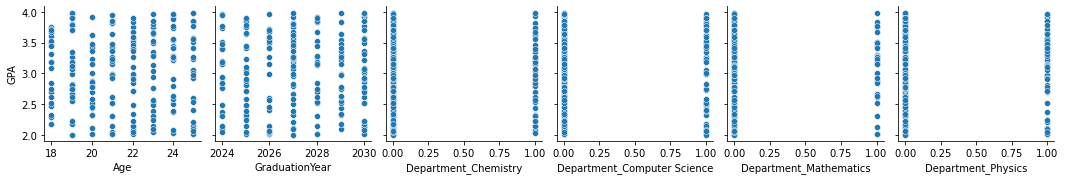

In [34]:
# Pairplot to visualize relationships
sns.pairplot(students_data_cleaned, y_vars='GPA', x_vars=['Age', 'GraduationYear'] + 
             [col for col in students_data_cleaned.columns if col.startswith('Department_')])
plt.show()


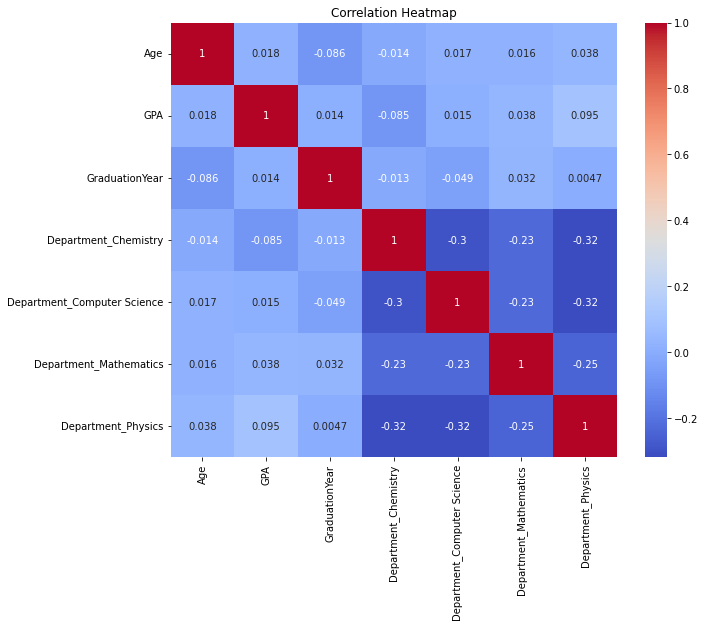

In [33]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(students_data_cleaned.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

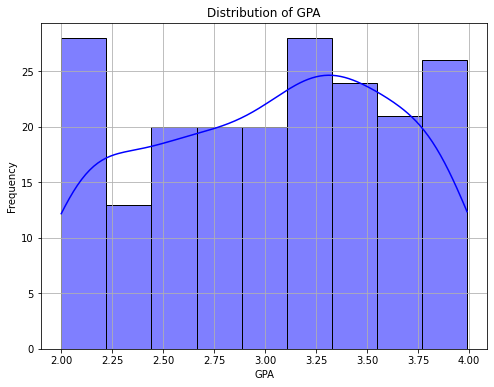

In [36]:
# Plot histogram for GPA
plt.figure(figsize=(8, 6))
sns.histplot(students_data_cleaned['GPA'], kde=True, color='blue')
plt.title('Distribution of GPA')
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### **4. Model Building**
- Build a multiple regression model using `GPA` as the dependent variable.
- Use the following predictors:
  - `Age`
  - `GraduationYear`
  - Encoded `Department`
- Evaluate the model's performance using metrics such as:
  - R-squared
  - Mean Squared Error (MSE)
  - Residual plots.


In [37]:
#Define the response variable and predictors
X = students_data_cleaned.drop(columns=['GPA'])  # All predictors
y = students_data_cleaned['GPA']  # Response variable

#Add a constant to include the intercept in the model
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
full_model = sm.OLS(y, X).fit()

# Display the model summary
print(full_model.summary())

# Extract coefficients and other metrics into a DataFrame
model_summary_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': full_model.params,
    'P-value': full_model.pvalues
}).reset_index(drop=True)

print(model_summary_df)


                            OLS Regression Results                            
Dep. Variable:                    GPA   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.6199
Date:                Tue, 24 Dec 2024   Prob (F-statistic):              0.714
Time:                        13:14:13   Log-Likelihood:                -176.23
No. Observations:                 200   AIC:                             366.5
Df Residuals:                     193   BIC:                             389.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

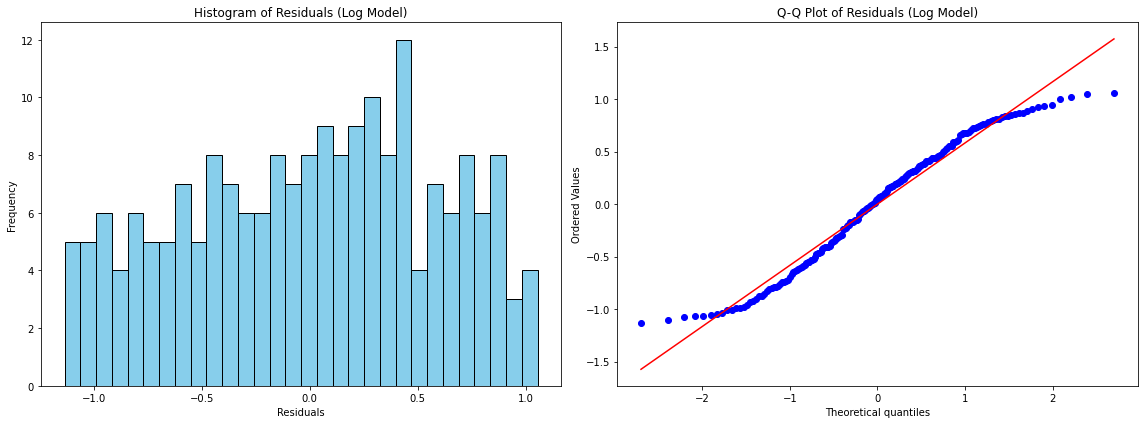

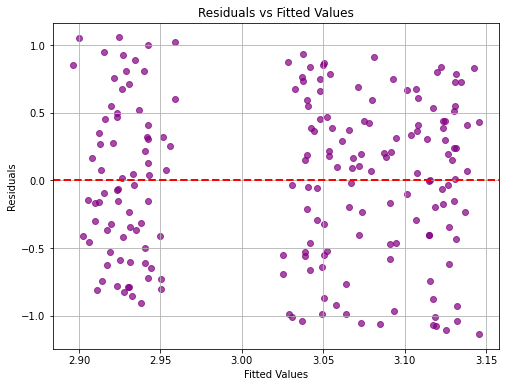

In [40]:
# Residuals and fitted values for the log-transformed model
log_residuals = full_model .resid
log_fitted_values = full_model.fittedvalues

#Residual Normality: Histogram and Q-Q Plot
plt.figure(figsize=(16, 6))

# Histogram of residuals
plt.subplot(1, 2, 1)
plt.hist(log_residuals, bins=30, edgecolor='k', color='skyblue')
plt.title('Histogram of Residuals (Log Model)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(log_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Log Model)')

plt.tight_layout()
plt.show()

#Homoscedasticity: Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(log_fitted_values, log_residuals, alpha=0.7, color='purple')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


The residual analysis reveals some violations of the regression model's assumptions. The histogram of residuals shows an approximately symmetric distribution, but deviations from normality are evident, particularly in the tails, suggesting the residuals are not perfectly normally distributed. The Q-Q plot confirms this, as several points deviate from the diagonal red line, especially at the extremes, indicating potential skewness or the presence of outliers. The residuals vs. fitted values plot shows patterns of clustering and non-random scatter, violating the assumption of homoscedasticity (constant variance). These clusters suggest that the variance of the residuals may depend on the fitted values, which undermines the model's validity. Overall, these issues indicate that the model fails to fully meet the assumptions of multiple linear regression, and further adjustments or alternative modeling approaches may be needed.

### **Conclusion**

This project aimed to predict GPA using multiple regression analysis with predictors including age, graduation year, and department. While the initial analysis provided insights into the relationships between variables, the results indicate that the chosen predictors have limited explanatory power for GPA, as evidenced by their insignificant p-values and weak correlations with the target variable. Furthermore, the residual analysis revealed violations of key regression assumptions, including deviations from normality and evidence of heteroscedasticity, suggesting that the model does not fully capture the variability in GPA. 

These findings highlight the need to explore additional predictors or interaction terms that could better explain GPA. Future work could involve incorporating variables such as study habits, attendance, or course difficulty, as well as considering transformations or non-linear models to address the observed issues. While the current model provides a foundation, significant improvements are needed to enhance its predictive accuracy and meet the assumptions of linear regression.